<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Equalization_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comparison of Equalization Techniques

Let us assume a signal $X[\cdot]$ of interest is filtered by a causal finite duration filter with impulse response $h$. To that we add i.i.d. gaussian noise $W[\cdot]$ with standard deviation $\sigma$. We thus observe $Y[\cdot] = \underbrace{(X * h)[\cdot]}_{Z[\cdot]} + W[\cdot]$ and wish to estimate $X$.

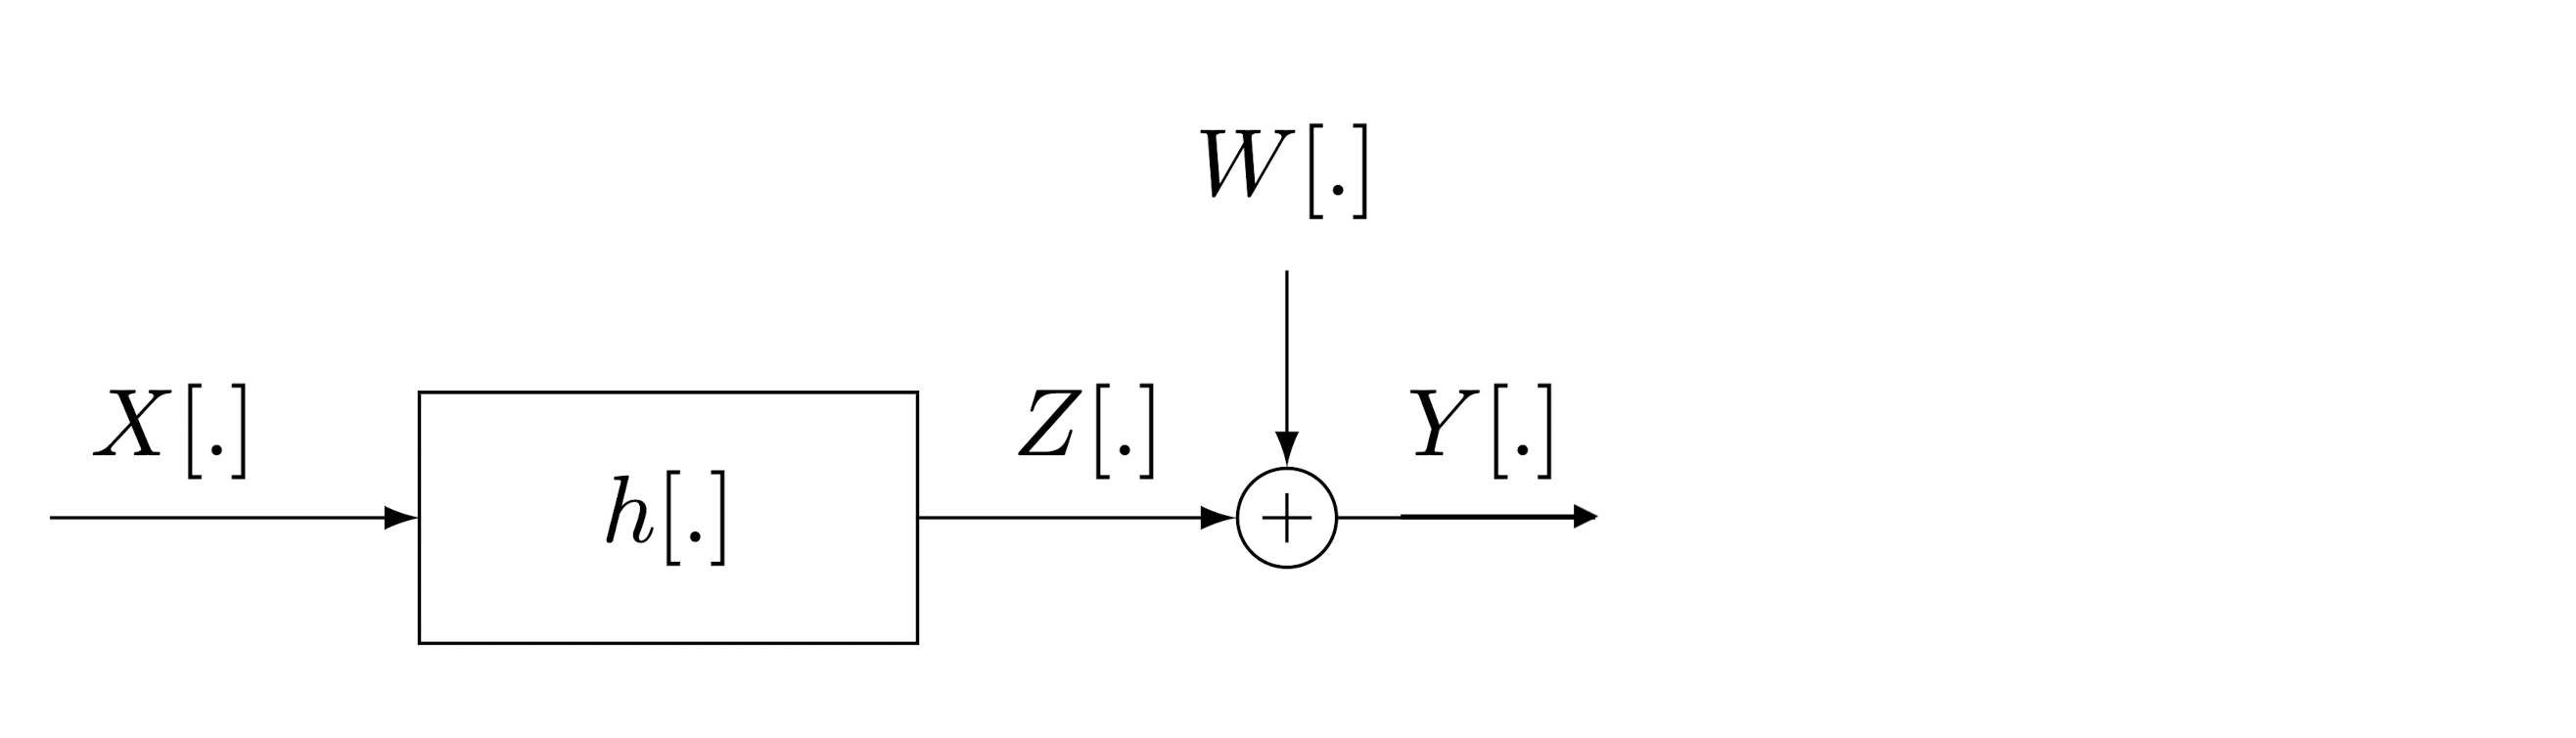

In order to be able to use all types of equalization techniques from the course we restrict ourselves to a digital signal, i.e. the signal is not only discrete time, but also only takes on values in a finite set called constellation.

In [5]:
import ipywidgets as widgets
#read in parameters
#-------------------------------------------------------------------------------
NG = 4
MG = [1, -1] #message is binary as standard
xG = None
hG = [0.5, 1]
sigmaG = 0.5

def update_parameters(M, h, x, sigma):
  global NG, MG, xG, hG, sigmaG
  try:
    MG = [float(v) for v in M.split()]
    hG = [float(v) for v in h.split()]
    xG = [float(v) for v in x.split()]
    for v in xG:
      if v not in MG:
        raise
    NG = len(xG)
    sigmaG = sigma
    print("")
  except:
    print("make sure the entered values are valid (e.g. x takes values in M)")
widgets.interact(update_parameters, M = '1 -1', h = '0.5 1', x  = widgets.Textarea(
    value='1 1 -1 -1 1 1 1 1 -1 -1 -1 -1 -1 1 1 1 1 -1 -1 -1 -1 -1 1 1 1 -1 1 1 1 -1 1 -1 1 -1',
    description='x'), sigma = widgets.FloatSlider(value=0.5, min=0, max=2));

interactive(children=(Text(value='1 -1', description='M'), Text(value='0.5 1', description='h'), Textarea(valu…

Above you can set the parameters of the equalization. $h$ is the impulse response of the causal FIR filter, $M$ describes the constellation and $x$ is the original signal (supposing at $t < 0$ we pad with $0$ and after the indicated values we no longer care about $x$). Let us generate the received values $y$ by filtering with $h$ and adding gaussian noise afterwards.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


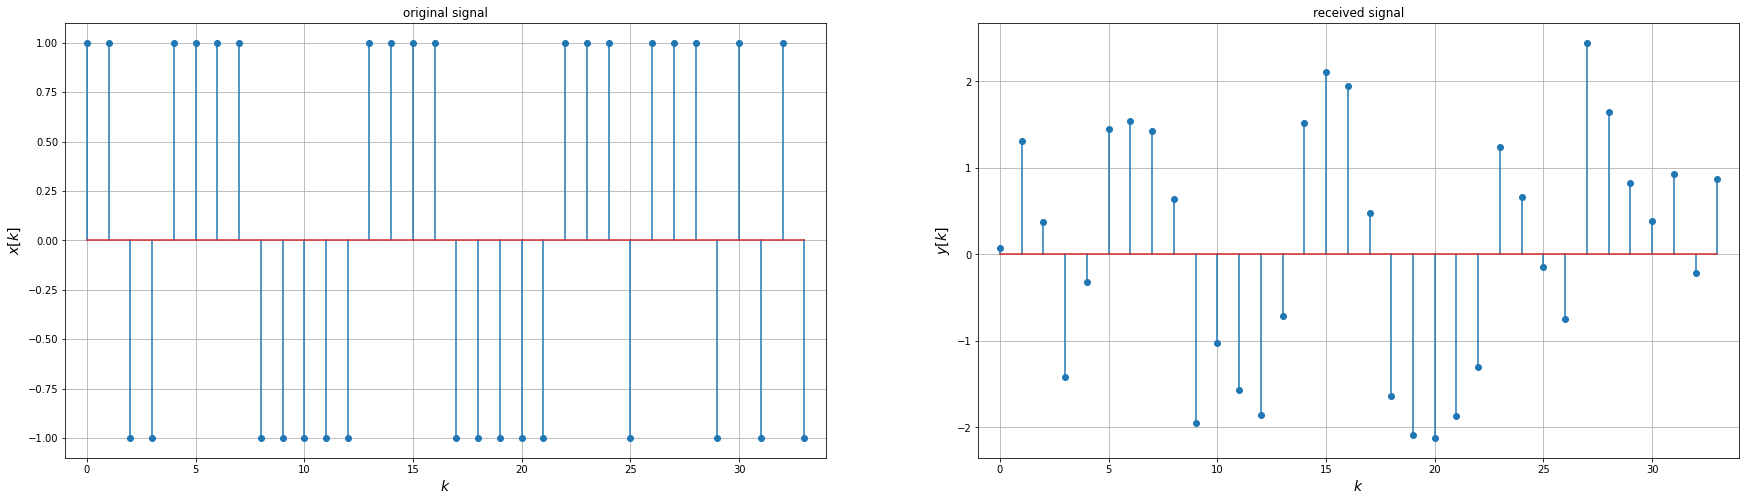

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#generate the signals
#-------------------------------------------------------------------------------
zG = np.convolve(xG, hG)
zG = zG[:len(xG)] #gets rid of values at end of signal about which we do not care
yG = zG + np.random.normal(0, sigmaG, zG.shape)

#plot the signals
#-------------------------------------------------------------------------------
fig = plt.figure(figsize=(30, 8))

ax1 = fig.add_subplot(1, 2, 1)
ax1.grid()
ax1.set_title('original signal')
ax1.set_xlabel('$k$', fontsize=14)
ax1.set_ylabel('$x[k]$', fontsize=14)
ax1.axis(xmin=-1, xmax=len(xG))
ax1.stem(xG);

ax2 = fig.add_subplot(1, 2, 2)
ax2.grid()
ax2.set_title('received signal')
ax2.set_xlabel('$k$', fontsize=14)
ax2.set_ylabel('$y[k]$', fontsize=14)
ax2.axis(xmin=-1, xmax=len(yG))
ax2.stem(yG);

Now that the problem has been set up, let us go on and try to perform different kinds of equalization techniques that we have learnt in this course so far.

## LMS Equalization

In [4]:
!gdown https://drive.google.com/uc?id=1yLrvj5InnE66yTFiBrKaEbQEGA0HU7Eg

Downloading...
From: https://drive.google.com/uc?id=1yLrvj5InnE66yTFiBrKaEbQEGA0HU7Eg
To: /content/LMS_equalizer.py
100% 2.38k/2.38k [00:00<00:00, 2.01MB/s]


In [ ]:
pip install pydsm

To use LMS equalization we first have to run the filter in adaptive mode. To that end we simulate the transmission (as outlined above) numerically to then be able to feed both $y$ and $x$ to the filter. You may set a custom standard deviation for the simulated data (how does this affect the performance of the LMS algorithm?).

In [ ]:
sigmaG_LMS = 0.5
def set_sigmaG_lms(sigma):
  global sigmaG_LMS
  sigmaG_LMS = sigmaG

widgets.interact(set_sigmaG_lms, 
  sigma = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=2,
    step=0.01,
    description='sigma_lms',
    readout_format ='.2f'),
  leng = widgets.IntSlider(
    value=len(hG),
    min=len(hG),
    max=10*len(hG),
    description='len(g)'));

In [ ]:
import numpy as np

x_sim = np.random.choice(MG, size = (NG*100)) #10 times the length of original signal may be used for training
z_sim = np.convolve(x_sim, hG)
z_sim = z_sim[:len(x_sim)] #gets rid of values at end of signal
y_sim = z_sim + np.random.normal(0, sigmaG_LMS, z_sim.shape)

print("x: ", x_sim[:10] , "...")
print("\nz: ",z_sim[:10], "...")
print("\ny: ",y_sim[:10], "...")

Having generated fake $X$ and $Y$ values, let us run LMS. To use LMS, we need to set initial coefficients for the equalization filter and a learning rate. To make matters simpler the coefficients will be initialized to 0, only the learning rate $\beta$ and the length of the inverse filter $len(g)$ may be adjusted.

In [ ]:
betaG = 0.025
lengG = len(hG)
def set_learning_rate(beta, leng):
  global betaG, lengG
  betaG, lengG = beta, leng

widgets.interact(set_learning_rate, 
  beta = widgets.FloatSlider(
    value=0.025,
    min=0,
    max=0.05,
    step=0.001,
    description='beta',
    readout_format ='.3f'),
  leng = widgets.IntSlider(
    value=len(hG),
    min=len(hG),
    max=10*len(hG),
    description='len(g)'));

Let us finally run the LMS algorithm. Hopefully a good learning rate and length of inversion filter was chosen.

In [ ]:
import LMS_equalizer

G, E = LMS_equalizer.LMS_adapt(y_sim, x_sim, np.zeros(lengG), betaG);
LMS_equalizer.plot_LMS(G, E)

g_final = G[-1]

Now that we trained the coefficients using LMS let us perform the estimation on the actual received signal $Y$.

In [ ]:
x_lms = np.convolve(yG, g_final)
x_lms = x_lms[:len(yG)]
print(x_lms)

## Viterbi Equalization

In [7]:
!gdown https://drive.google.com/uc?id=13hHW9STc3wfArt1gw0hynjSV74pwX3M6

Downloading...
From: https://drive.google.com/uc?id=13hHW9STc3wfArt1gw0hynjSV74pwX3M6
To: /content/viterbi_equalizer.py
100% 6.51k/6.51k [00:00<00:00, 12.2MB/s]


In [9]:
import viterbi_equalizer

viterbi_equalizer.set_parameters(NG, MG, yG, hG)
with viterbi_equalizer.HiddenPrints():
  state_descriptions, branch_metrics = viterbi_equalizer.construct_trellis();
  x_viterbi = viterbi_equalizer.invoke_viterbi(state_descriptions, branch_metrics);

print(x_viterbi)

[1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0]
